In [12]:
# 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install -y fonts-nanum

# Matplotlib 폰트 설정
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib

# 나눔고딕 폰트 경로 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_manager.fontManager.addfont(font_path)
rc('font', family='NanumGothic', size=12)

# 마이너스 폰트 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

print("폰트 설정 완료 - NanumGothic 적용됨")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
폰트 설정 완료 - NanumGothic 적용됨


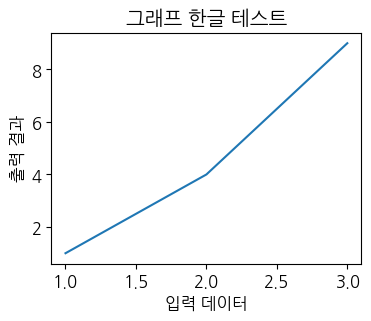

In [13]:
# ===== 테스트 그래프 =====
plt.figure(figsize=(4,3))
plt.title("그래프 한글 테스트")
plt.plot([1,2,3],[1,4,9])
plt.xlabel("입력 데이터")
plt.ylabel("출력 결과")
plt.show()

In [14]:
import torch
import torch.nn as nn

In [15]:
# U-Net 생성자(Generator) 클래스 정의
# 결론: skip connection 은 모든 up_conv_layer_X에 적용된다.
# 디코더에서 전체적인 맥락 유지, 인코더에서 (색상, 질감) 보존해서 복원 (스킵커넥션)
class UNetGenerator(nn.Module):
  def __init__(self, chnls_in=3, chnls_op=3):
    super(UNetGenerator, self).__init__()

  # 인코더(다운샘플링) 블록  >> 특징 추출
  # DownConvBlock 은 해상도를 줄이고 채널을 늘림
    self.down_conv_layer1 = nn.DownConvBlock(chnls_in, 64, norm=False)
    # 초기 블럭은 정규화 제외 (원본에 가깝게)
    self.down_conv_layer2 = nn.DownConvBlock(64, 128)
    self.down_conv_layer3 = nn.DownConvBlock(128, 256)
    # 깊은 레이어에는 채널은 유지(512) 드롭아웃 적용 하여 과적합 방지
    self.down_conv_layer4 = nn.DownConvBlock(256, 512, dropout=0.5)
    self.down_conv_layer5 = nn.DownConvBlock(512, 512, dropout=0.5)
    self.down_conv_layer6 = nn.DownConvBlock(512, 512, dropout=0.5)
    self.down_conv_layer7 = nn.DownConvBlock(512, 512, dropout=0.5)
    # 병목(bottle-neck) 부분 : 해상도 변경 없음. 정규화, 드랍아웃 비활성화/활성화 옵션 적용
    self.down_conv_layer8 = nn.DownConvBlock(512, 512, norm=False, dropout=0.5)

  # 디코더(업샘플링) 블록
  # UpConvBlock 은 해상도를 늘리고(2배씩) concat 해서 채널을 합치고 채널 수를 줄입니다.
  # skip-connection 통해 인코더 출력을 받음
  # UpConvBlock의 입력 채널 (이전 디코더의 출력 채널 + 해당 인코더 출력 채널)
  # 병목 특징(enc8) 시작

    self.up_conv_layer1 = nn.UpConvBlock(512,512, dropout=0.5)
    self.up_conv_layer2 = nn.UpConvBlock(1024,512, dropout=0.5)
    # 512(dec1) + 512(enc6) >> 1024 >> 1024를 받아서 512 출력
    self.up_conv_layer3 = nn.UpConvBlock(1024,512, dropout=0.5)
    self.up_conv_layer4 = nn.UpConvBlock(1024,256, dropout=0.5)
    # 이전 dec + skip-connection = 512+512 = 1024
    self.up_conv_layer5 = nn.UpConvBlock(512,128)
    # 이전 dec + skip-connection = 256+128
    self.up_conv_layer6 = nn.UpConvBlock(256,64)
    #128 + 64
    self.up_conv_layer7 = nn.UpConvBlock(128,64)
    # 64 + 64

    # 최종 출력 레이어 정의
    # 최종 해상도 복원하기 위한 업샘플링 레이어 정의
    self.upsample_layer = nn.Upsample(scale_factor=2)
    # 최종 합성곱 전에 패딩을 위한 레이어 정의
    self.zero_pad = nn.ZeroPad2d((1,0,1,0))
    # nn.ZeroPad2d((left, right, top, down)) px에 0으로 채워라

    # 최종 출력 채널(chnls_op)을 맞추기 위한 합성곱 레이어 정의
    self.conv_layer1 = nn.Conv2d(64, chnls_op, 4, padding=1)
    # 입력 채널 64, chnls_op 3(RGB), 4: kernel_size

    # 최종 출력 픽셀 값 [-1,1] 범위 제한 >> Tanh 활성화함수
    self.activation = nn.Tanh()

  # 데이터 순전파 정의
  def forward(self, x):
    # 인코딩 경로
    # 각 다운 샘플링 블록 통과 >> 출력 enc1 - enc8 에 저장(skip-connection)
    enc1 = self.down_conv_layer1(x)     # 가장 얇은 특징 (입력이미지와 해상동 유지)
    enc2 = self.down_conv_layer2(enc1)
    enc3 = self.down_conv_layer3(enc2)
    enc4 = self.down_conv_layer4(enc3)
    enc5 = self.down_conv_layer5(enc4)
    enc6 = self.down_conv_layer6(enc5)
    enc7 = self.down_conv_layer7(enc6)
    enc8 = self.down_conv_layer8(enc7)   # 병목(bottle-neck) 특징(해상도는 가장 낮아, 압축되어 있는 고수준 특징)
    # 채널 변화 enc1 64, enc2 128 enc3 256, enc4-enc8 512

    # 디코딩 경로(스킵 커넥션 포함)
    # 업샘플링 블록 통과 >> 이전 디코더 출력(decX)과 해당 인코더 출력(encY) 를 입력으로 받음
    dec1 = self.up_conv_layer1(enc8, enc7) # enc8(병목)이 디코딩의 시작, enc7 (스킵커넥션)
    dec2 = self.up_conv_layer1(dec1, enc6)
    dec3 = self.up_conv_layer1(dec2, enc5)
    dec4 = self.up_conv_layer1(dec3, enc4)
    dec5 = self.up_conv_layer1(dec4, enc3)
    dec6 = self.up_conv_layer1(dec5, enc2)
    dec7 = self.up_conv_layer1(dec6, enc1) # 인코딩 경로 가장 얕은 특징과 결합
    # dec7 : 해상도가 가장 높고 채널수는 가장 적어요(64채널)
    # dec1 = self.up_conv_layer1(enc8, enc7) # enc8(병목)이 디코딩의 시작, enc7 (스킵커넥션)
    # enc8(512)+enc7(512) = 1024 >> conv(1024)>> 512

    # dec1 = self.up_conv_layer1(enc8, enc7)
    # 총입력채널 (이전 dec: enc8 512. 스킵커넥션 enc7 512) 총입력채널 1024 출력 512
    # dec2 = self.up_conv_layer1(dec1, enc6)
    # 총입력채널 (이전 dec: dec1 512. 스킵커넥션 enc6 512) 총입력채널 1024 출력 512
    # dec3 = self.up_conv_layer1(dec2, enc5)
    # 총입력채널 (이전 dec: dec2 512. 스킵커넥션 enc5 512) 총입력채널 1024 출력 512
    # dec4 = self.up_conv_layer1(dec3, enc4)
    # 총입력채널 (이전 dec: dec3 512. 스킵커넥션 enc4 512) 총입력채널 1024 출력 256

    # dec5 = self.up_conv_layer1(dec4, enc3)
    # 총입력채널 (이전 dec: dec4 256, 스킵커넥션 enc3 256) 총입력채널 512 출력 128
    # dec6 = self.up_conv_layer1(dec5, enc2)
    # 총입력채널 (이전 dec: dec5 128, 스킵커넥션 enc2 128) 총입력채널 256 출력 64
    # dec7 = self.up_conv_layer1(dec6, enc3)
    # 총입력채널 (이전 dec: dec6 64, 스킵커넥션 enc1 64) 총입력채널 128 출력 64

    # 최종 출력
    # 마지막 디코더 출력(dec7)을 최종적으로 한 번 더 업샘플링함
    final = self.upsample_layer(dec7)

    # 최종 합성곱을 위한 패딩 적용
    final = self.zero_pad(final)
    # 최종 합성곱 레이어를 통과 >> 출력 채널
    final = self.conv_layer1(final)

    # Tanh 활성화 함수 통과 >> 최종 이미지 반환
    return self.activation(final)

In [16]:
# U-Net의 업샘플링 합성곱 블록 클래스를 정의함.
class UpConvBlock(nn.Module):
    # 모듈 초기화. ip_sz: 입력 채널, op_sz: 출력 채널, dropout: 드롭아웃 확률을 받음.
    def __init__(self, ip_sz, op_sz, dropout=0.0):
        super(UpConvBlock, self).__init__()

        # 블록을 구성할 레이어 리스트를 정의함.
        self.layers = [
            # 전치 합성곱(ConvTranspose2d)을 사용해 업샘플링함. 커널 4, 스트라이드 2, 패딩 1로 해상도를 2배로 높임.
            nn.ConvTranspose2d(ip_sz, op_sz, 4, 2, 1),
            # 배치 정규화 대신 인스턴스 정규화(InstanceNorm2d)를 적용함. (Pix2Pix GAN에서 흔히 사용됨)
            # 배치 전체가 아닌 개별 샘플(instance) 정규화 이미지vs이미지
            nn.InstanceNorm2d(op_sz),
            # ReLU 활성화 함수를 적용함.
            nn.ReLU(),
        ]

        # 드롭아웃 확률이 0.0보다 크면 드롭아웃 레이어를 추가함.
        if dropout:
            self.layers += [nn.Dropout(dropout)]

    # 순전파 함수를 정의함. x: 이전 디코더 출력, enc_ip: 스킵 커넥션으로 받은 인코더 출력을 입력받음.
    def forward(self, x, enc_ip):
        # 정의된 레이어들을 nn.Sequential로 묶어 x를 통과시킴.
        x = nn.Sequential(*(self.layers))(x)

        # 업샘플링된 결과(x)와 해당 인코더 출력(enc_ip)(특징맵)을 채널 차원(1번)을 따라 결합(concatenate)함.
        op = torch.cat((x, enc_ip), 1)

        # 결합된 특징 맵을 반환함. (디코더 블록의 입)
        return op

In [17]:
# U-Net의 다운샘플링 합성곱 블록 클래스를 정의함.
class DownConvBlock(nn.Module):
    # 모듈 초기화. ip_sz: 입력 채널, op_sz: 출력 채널, norm: 정규화 사용 여부, dropout: 드롭아웃 확률을 받음.
    def __init__(self, ip_sz, op_sz, norm=True, dropout=0.0):
        super(DownConvBlock, self).__init__()

        # 첫 번째 레이어: 4x4 합성곱을 정의함. stride=2, padding=1로 해상도를 절반으로 줄임.
        self.layers = [nn.Conv2d(ip_sz, op_sz, 4, 2, 1)]

        # 정규화(norm)가 True인 경우 인스턴스 정규화 레이어를 추가함.
        if norm:
            self.layers.append(nn.InstanceNorm2d(op_sz))

        # Leaky ReLU 활성화 함수를 추가함.
        self.layers += [nn.LeakyReLU(0.2)]
        # 음수값에 대해 0.2 기울기 허용

        # 드롭아웃 확률이 0.0보다 큰 경우 드롭아웃 레이어를 추가함.
        if dropout:
            self.layers += [nn.Dropout(dropout)]

    # 순전파 함수를 정의함.
    def forward(self, x):
        # 정의된 레이어들을 nn.Sequential로 묶어 x를 통과시킴.
        op = nn.Sequential(*(self.layers))(x)

        # 최종 특징 맵(op)을 반환함.
        return op

In [18]:
# Pix2Pix 판별자 클래스를 정의함.
class Pix2PixDiscriminator(nn.Module):
    # 모델의 레이어들을 정의하여 초기화함. chnls_in: 입력 이미지 채널 수를 받음.
    def __init__(self, chnls_in=3):
        super(Pix2PixDiscriminator, self).__init__()

        # 합성곱, 정규화, 활성화 함수로 구성된 판별 블록을 정의하는 헬퍼 함수임.
        def disc_conv_block(chnls_in, chnls_op, norm=1):
            # 4x4 합성곱, stride=2, padding=1로 해상도를 절반으로 줄임.
            layers = [nn.Conv2d(chnls_in, chnls_op, 4, stride=2, padding=1)]

            # 정규화(norm)가 True인 경우 인스턴스 정규화 레이어를 추가함.
            if normalization: # 'normalization' 변수가 클래스 외부에서 정의되었다고 가정함.
                layers.append(nn.InstanceNorm2d(chnls_op))

            # Leaky ReLU 활성화 함수를 추가함.
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 첫 번째 레이어(lyr1): 입력 이미지(실제 + 생성)를 결합하므로 채널은 chnls_in * 2임.
        # 정규화는 사용하지 않음(norm=0).
        self.lyr1 = disc_conv_block(chnls_in * 2, 64, norm=0)
        # 두 번째 레이어(lyr2): 64채널을 128채널로 변환함.
        self.lyr2 = disc_conv_block(64, 128)
        # 세 번째 레이어(lyr3): 128채널을 256채널로 변환함.
        self.lyr3 = disc_conv_block(128, 256)
        # 네 번째 레이어(lyr4): 256채널을 512채널로 변환함.
        self.lyr4 = disc_conv_block(256, 512)

    # 데이터의 순전파 경로를 정의함.
    def forward(self, real_image, translated_image):
        # 실제 이미지와 생성된 이미지를 채널 차원(1번)을 따라 결합하여 입력(ip)을 만듦.
        # Pix2Pix 조건부 GAN
        ip = torch.cat((real_image, translated_image), 1)

        # 합성곱 블록들을 순서대로 통과시킴.
        # 해상도는 점진적으로 줄어들어요(다운샘플링)>>채널은 늘어남
        op = self.lyr1(ip)
        op = self.lyr2(op)
        op = self.lyr3(op)
        op = self.lyr4(op)

        # 최종 합성곱 레이어 전 패딩을 적용함.
        op = nn.ZeroPad2d((1, 0, 1, 0))(op)
        # 최종 512채널을 1채널 출력으로 변환하는 합성곱 레이어를 통과시킴.
        op = nn.Conv2d(512, 1, 4, padding=1)(op)

        # 최종 패치별 진위 여부 예측 맵을 반환함. (Sigmoid는 외부에서 적용될 수 있음)
        return op

pix2pix 실습

In [19]:
import torch                          # 파이토치 기본 모듈을 불러옴
import torch.nn as nn                 # 신경망 레이어를 제공하는 nn 모듈을 불러옴
import torch.nn.functional as F       # 보조 함수들(ReLU, interpolate 등)을 제공하는 F 모듈을 불러옴
from torch.utils.data import DataLoader, Subset  # 미니배치 생성을 위한 DataLoader와 Subset을 불러옴

import torchvision                    # 토치비전(이미지용 데이터셋/모듈)을 불러옴
import torchvision.transforms as T    # 이미지 변환을 위한 transforms 모듈을 불러옴

import matplotlib.pyplot as plt       # 시각화를 위한 matplotlib.pyplot을 불러옴
import numpy as np                   # 텐서를 넘파이로 바꿔서 그림에 쓰기 위해 numpy를 불러옴

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda, 없으면 cpu를 선택함
print("사용 중인 device:", device)                                     # 현재 선택된 device를 출력함


사용 중인 device: cuda


In [20]:
# ===== Generator 구성(3채널 64x64 → 3채널 64x64) =====
G_layers = []                                        # 생성자 레이어들을 담을 리스트를 만듦

G_layers.append(nn.Conv2d(3, 64, 4, 2, 1))
# 3채널 입력을 64채널로 바꾸면서 크기를 64→32로 줄이는 합성곱
# 4: 커널크기, 2: stride (pooling 효과 대체), 1: padding
G_layers.append(nn.ReLU(inplace=True))               # ReLU 활성화 함수를 추가함

G_layers.append(nn.Conv2d(64, 128, 4, 2, 1))         # 64채널→128채널, 크기 32→16으로 줄이는 합성곱
G_layers.append(nn.BatchNorm2d(128))                 # 128채널에 대해 배치 정규화를 수행함
G_layers.append(nn.ReLU(inplace=True))               # ReLU 활성화 함수를 추가함

G_layers.append(nn.ConvTranspose2d(128, 64, 4, 2, 1)) # 전치합성곱으로 크기를 16→32로 키우면서 128→64채널로 바꿈
G_layers.append(nn.BatchNorm2d(64))                   # 64채널 배치 정규화
G_layers.append(nn.ReLU(inplace=True))                # ReLU 활성화 함수를 추가함

G_layers.append(nn.ConvTranspose2d(64, 3, 4, 2, 1))   # 전치합성곱으로 크기를 32→64로 키우면서 3채널(RGB)로 출력함
G_layers.append(nn.Tanh())                            # 출력 값을 [-1, 1] 범위로 제한하기 위해 Tanh를 사용함

G = nn.Sequential(*G_layers)                          # 리스트에 쌓은 레이어들을 nn.Sequential로 묶어 하나의 모델로 만듦
G = G.to(device)                                      # 생성자를 GPU 또는 CPU로 이동시킴

# ===== Discriminator 구성(입력 3채널 + 타깃 3채널 = 6채널) =====
D_layers = []                                         # 판별기 레이어들을 담을 리스트를 만듦

D_layers.append(nn.Conv2d(6, 64, 4, 2, 1))
# 6채널 입력을 64채널로 바꾸면서 크기를 64→32로 줄이는 합성곱
# 채널 (입력이미지 채널 3, 타겟이미지 채널 3)
D_layers.append(nn.LeakyReLU(0.2, inplace=True))      # LeakyReLU 활성화로 음수도 조금 통과시키게 함

D_layers.append(nn.Conv2d(64, 128, 4, 2, 1))          # 64채널→128채널, 크기 32→16으로 줄이는 합성곱
D_layers.append(nn.BatchNorm2d(128))                  # 128채널 배치 정규화
D_layers.append(nn.LeakyReLU(0.2, inplace=True))      # LeakyReLU 활성화를 사용함

D_layers.append(nn.Conv2d(128, 256, 4, 2, 1))         # 128채널→256채널, 크기 16→8로 줄이는 합성곱
D_layers.append(nn.BatchNorm2d(256))                  # 256채널 배치 정규화
D_layers.append(nn.LeakyReLU(0.2, inplace=True))      # LeakyReLU 활성화를 사용함

D_layers.append(nn.Conv2d(256, 1, 4, 1, 1))           # 256채널→1채널 출력, Patch 단위 진짜/가짜 점수 맵을 출력함

D = nn.Sequential(*D_layers)                          # 레이어들을 nn.Sequential로 묶어 판별기 모델을 만듦
D = D.to(device)                                      # 판별기를 GPU 또는 CPU로 이동시킴

# ===== 한 번만 더미 입력으로 동작 테스트 =====
dummy_x = torch.randn(1, 3, 64, 64, device=device)    # 3채널 64x64 더미 입력 이미지를 하나 만듦
# 1: 배치크기, 3채널, 크기 64*64
dummy_y = torch.randn(1, 3, 64, 64, device=device)    # 3채널 64x64 더미 타깃 이미지를 하나 만듦

dummy_fake = G(dummy_x)                               # 생성자를 통과시켜 가짜 이미지(생성이미지)를 생성함
print("생성자 출력 크기:", dummy_fake.shape)          # 생성자 출력 텐서 크기를 확인함

dummy_pair = torch.cat([dummy_x, dummy_y], dim=1)     # (입력, 타깃)을 채널 방향으로 합쳐 6채널 텐서를 만듦
dummy_disc = D(dummy_pair)                            # 판별기를 통과시켜 PatchGAN 출력 맵을 얻음
print(dummy_pair.shape)
print("판별기 출력 크기:", dummy_disc.shape)          # 판별기 출력 텐서 크기를 확인함
# 왜 판별기 출력 크기: torch.Size([1, 1, 7, 7]) 패치 단위 점수 맵
# b,c,h,w (이미지 패치크기)
# 7*7 = 49 (패치)
# 49개 패치 각각에 대한 real/fake 스코어 맵(score map)

생성자 출력 크기: torch.Size([1, 3, 64, 64])
torch.Size([1, 6, 64, 64])
판별기 출력 크기: torch.Size([1, 1, 7, 7])


In [21]:
# MNIST 원본 이미지를 텐서로 읽어오기 위한 변환을 정의함
transform = T.ToTensor()                                # 이미지를 [0,1] 범위의 (1,28,28) 텐서로 바꾸는 변환임

# MNIST 학습용 데이터셋을 다운로드하고 불러옴 (처음 한 번만 다운로드됨)
mnist_full = torchvision.datasets.MNIST(
    root="./data",                                      # 데이터를 저장할 경로를 지정함
    train=True,                                         # 학습용(train) 데이터를 사용함
    download=True,                                      # 데이터가 없으면 자동으로 다운로드함
    transform=transform                                 # 위에서 정의한 ToTensor 변환을 적용함
)

# 너무 오래 걸리지 않도록 일부 샘플만 사용함
num_samples = 2000                                      # 전체 데이터 중 2000개만 사용하도록 설정함
indices = torch.randperm(len(mnist_full))[:num_samples] # 데이터 인덱스를 무작위로 섞은 뒤 앞에서 2000개만 선택함
mnist_subset = Subset(mnist_full, indices)              # 선택한 인덱스들만 포함하는 Subset을 만듦
# torch.randperm(n) : 0 ~ n-1 까지 숫자를 무작위로 섞은 리스트 생성

batch_size = 64                                         # 한 번에 처리할 미니배치 크기를 64로 설정함
loader = DataLoader(
    mnist_subset,                                       # 위에서 만든 Subset을 사용함
    batch_size=batch_size,                              # 설정한 배치 크기를 사용함
    shuffle=True,                                       # 매 epoch마다 데이터를 섞어서 가져오게 함
    num_workers=2,                                      # 데이터를 병렬로 읽어올 작업자 수를 2로 설정함(Colab에서 무난한 값)
    pin_memory=True if device.type == "cuda" else False # GPU 사용 시 데이터를 pinned memory로 옮겨 전송 효율을 높임
)

# 한 배치를 꺼내서 입력/타깃 텐서가 어떻게 생겼는지 확인함
images, labels = next(iter(loader))                     # (이미지, 라벨) 배치를 하나 꺼냄 (이미지는 [B,1,28,28])

print("원본 MNIST 텐서 크기:", images.shape)           # 원본 이미지 텐서의 크기를 출력함


원본 MNIST 텐서 크기: torch.Size([64, 1, 28, 28])


In [22]:
criterion_gan = nn.BCEWithLogitsLoss().to(device)       # GAN 진짜/가짜 판별에 사용할 BCEWithLogitsLoss를 device 위로 올림

# BCEWithLogitsLoss() : gan 등 이미지 생성 모델 많이 사용됨
# - sigmoid() >>  bce 계산

criterion_l1 = nn.L1Loss().to(device)                   # L1 픽셀 차이 손실 함수를 device 위로 올림

# L1Loss()
# 두 이미지 픽셀 파이 절대값 평균

lr = 0.0002                                             # 학습률(learning rate)을 0.0002로 설정함
beta1 = 0.5                                             # Adam 옵티마이저의 beta1 파라미터를 0.5로 설정함
# beta1 모멘텀 조절 값 (대부분 0.9)
# >> GAN 불안정한 데이터(노이즈) 훈련을 안정화하려고 모멘텀(기억)을 줄여줌

optimizer_G = torch.optim.Adam(
    G.parameters(), lr=lr, betas=(beta1, 0.999)         # 생성자 파라미터를 Adam으로 업데이트하도록 설정함
)
optimizer_D = torch.optim.Adam(
    D.parameters(), lr=lr, betas=(beta1, 0.999)         # 판별자 파라미터를 Adam으로 업데이트하도록 설정함
)

lambda_l1 = 100.0                                       # L1 손실에 곱해 줄 가중치 λ를 100으로 설정함 (pix2pix 논문 기본값)
# Gan loss 보다 L1 손실(픽셀 재구성)을 훨씬 더 중요하게 취급하겠어요.
# 실제 모양을 정확하게 재현하도록 만들어줌

In [25]:
num_epochs = 3                                          # 전체 데이터를 3번 반복(epoch)하면서 학습하도록 설정함

for epoch in range(num_epochs):                         # 각 epoch에 대해 반복함
    print(f"===== Epoch {epoch+1}/{num_epochs} =====")  # 현재 epoch 정보를 출력함

    for step, (imgs, labels) in enumerate(loader):      # DataLoader에서 (이미지, 라벨) 배치를 하나씩 꺼냄
        # ---- 1. 입력/타깃 이미지 만들기 ----
        imgs = imgs.to(device)                          # 원본 MNIST 이미지를 device(GPU/CPU)로 옮김 (크기 [B,1,28,28])

        imgs_64 = F.interpolate(
        # 이미지를 28x28에서 64x64로 업샘플링함(mode="bilinear 활용)
        # 이중 선형 보간법(두 방향, 수평/수직 선형보간해줌)
            imgs, size=(64, 64), mode="bilinear", align_corners=False

        )

        inputs = imgs_64.repeat(1, 3, 1, 1)             # 1채널 이미지를 채널 방향으로 3번 복사해 3채널 이미지를 만듦
        # imgs_64 (N,1,64,64)
        # repeat() 1: 원본이미지, 3: 채널차원(1) 세번 반복 (1*3=3), 1: h, 1: w
        # 결론 (N,3,64,64)

        inputs = inputs * 2 - 1                         # [0,1] 범위였던 값을 [-1,1] 범위로 스케일링함
        # inputs [0,1] >> [0, 2] >> [-1,1]
        # [-1,1] 정규화 해야 하나요?
        # gan이 활성화함수로 tanh [-1,1], tanh 0을 지나요 (데이터 평균을 0 근처로 맞추려고 해요)
        # >> gradient 기울기 특정 방향으로 편향 방지하는 효과, 데이터 대칭성(균형)

        # 색상 반전
        targets = 1 - imgs_64                           # 색 반전을 위해 1에서 이미지를 빼서 밝기 반전 이미지를 만듦
        # 1-P
        # 원본 검은색(0) 1-0 = 1 (흰색) >> (반전) 1-1 =0 (검은색)
        # 원본 회색 (0.5) (반전) 1-0.5 =0.5 (동일한 회색)
        targets = targets.repeat(1, 3, 1, 1)            # 마찬가지로 3채널로 복제함
        targets = targets * 2 - 1                       # 타깃도 [-1,1] 범위로 스케일링함

        # ---- 2. 판별기 D 학습 ----
        optimizer_D.zero_grad()                         # 판별기 기울기를 0으로 초기화함

        with torch.no_grad():                           # 생성자 업데이트 전, 가짜 이미지를 만들 때는 기울기가 필요 없음
            fake_tgt_for_D = G(inputs)                  # 생성자 G를 사용해 입력으로부터 가짜 타깃 이미지를 만듦

        real_pair = torch.cat([inputs, targets], dim=1) # (입력, 진짜 타깃)을 채널 방향으로 합쳐 6채널 텐서를 만듦
        fake_pair = torch.cat([inputs, fake_tgt_for_D], dim=1) # (입력, 가짜 타깃)을 합쳐 6채널 텐서를 만듦

        pred_real = D(real_pair)                        # 진짜 쌍에 대한 판별기 출력을 얻음
        pred_fake = D(fake_pair)                        # 가짜 쌍에 대한 판별기 출력을 얻음

        label_real = torch.ones_like(pred_real, device=device) # 진짜에는 1 라벨을 부여함
        label_fake = torch.zeros_like(pred_fake, device=device) # 가짜에는 0 라벨을 부여함

        loss_D_real = criterion_gan(pred_real, label_real)      # 진짜를 1로 분류하도록 하는 손실을 계산함
        loss_D_fake = criterion_gan(pred_fake, label_fake)      # 가짜를 0으로 분류하도록 하는 손실을 계산함

        loss_D = (loss_D_real + loss_D_fake) * 0.5              # 두 손실의 평균을 판별기 전체 손실로 사용함

        loss_D.backward()                          # 판별기 손실에 대해 역전파를 수행해 기울기를 계산함
        optimizer_D.step()                         # 판별기 파라미터를 한 스텝 업데이트함

        # ---- 3. 생성자 G 학습 ----
        optimizer_G.zero_grad()                         # 생성자 기울기를 0으로 초기화함

        fake_tgt = G(inputs)                            # 생성자 G로부터 가짜 타깃 이미지를 다시 생성함
        fake_pair_for_G = torch.cat([inputs, fake_tgt], dim=1)  # (입력, 가짜 타깃)을 합쳐 6채널 텐서를 만듦

        pred_fake_for_G = D(fake_pair_for_G)            # 판별기에 가짜 쌍을 넣어 출력을 얻음

        label_real_for_G = torch.ones_like(pred_fake_for_G, device=device)  # 생성자는 가짜가 진짜(1)처럼 보이게 만들고 싶어함

        loss_G_gan = criterion_gan(pred_fake_for_G, label_real_for_G)       # 판별기를 속이려는 GAN 손실을 계산함
        loss_G_l1 = criterion_l1(fake_tgt, targets) * lambda_l1             # 가짜와 진짜 이미지 차이에 대한 L1 손실을 계산하고 λ를 곱함

        loss_G = loss_G_gan + loss_G_l1                                     # 전체 생성자 손실은 GAN 손실과 L1 손실의 합임

        loss_G.backward()                          # 생성자 손실에 대해 역전파를 수행해 기울기를 계산함
        optimizer_G.step()                         # 생성자 파라미터를 한 스텝 업데이트함

        # ---- 4. 중간 로그 출력 ----
        if step % 50 == 0:                         # 50 스텝마다 한 번씩 학습 로그를 출력함
            print(
                f"[Epoch {epoch+1}/{num_epochs}] "
                f"Step {step}/{len(loader)} "
                f"Loss_D: {loss_D.item():.4f} "
                f"Loss_G: {loss_G.item():.4f} "
                f"(GAN: {loss_G_gan.item():.4f}, L1: {loss_G_l1.item():.4f})"
            )                                     # 현재 스텝의 손실 값을 보기 좋게 출력함


===== Epoch 1/3 =====
[Epoch 1/3] Step 0/32 Loss_D: 0.5732 Loss_G: 4.7709 (GAN: 1.3522, L1: 3.4187)
===== Epoch 2/3 =====
[Epoch 2/3] Step 0/32 Loss_D: 0.5319 Loss_G: 4.8498 (GAN: 1.6672, L1: 3.1826)
===== Epoch 3/3 =====
[Epoch 3/3] Step 0/32 Loss_D: 0.5852 Loss_G: 4.0919 (GAN: 1.0366, L1: 3.0552)


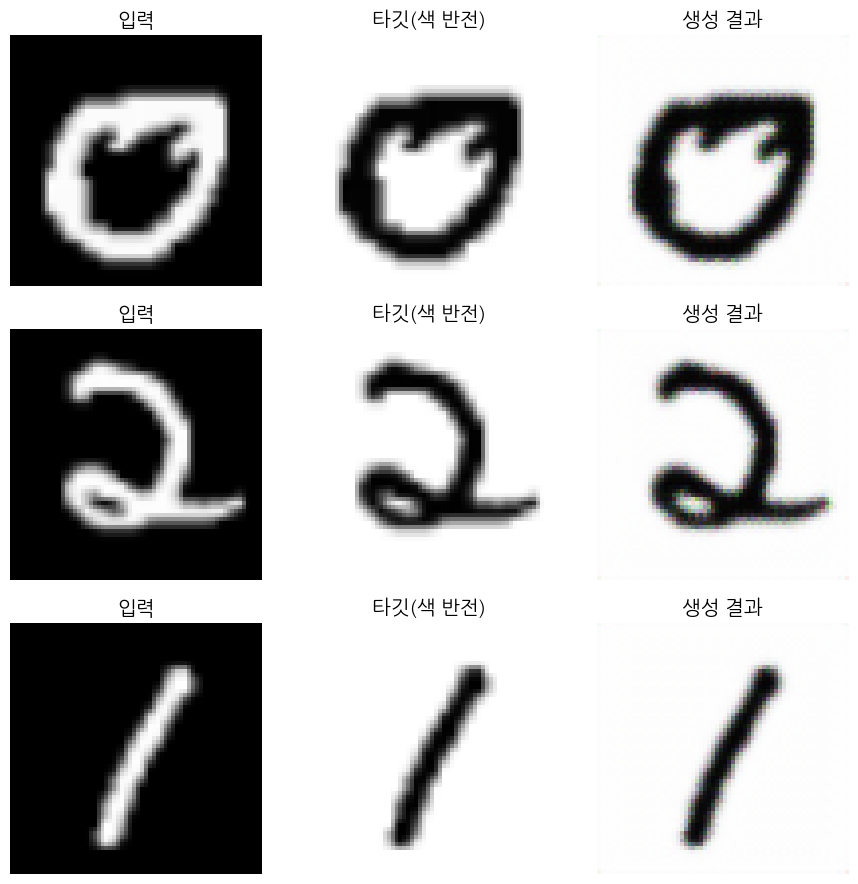

In [26]:
# DataLoader에서 한 배치(이미지, 라벨)를 꺼냄
imgs, labels = next(iter(loader))                 # 원본 MNIST 이미지와 라벨을 하나의 배치로 가져옴
imgs = imgs.to(device)                            # 이미지를 device로 옮김

# 위 학습 루프와 동일하게 입력/타깃 텐서를 다시 만들어 줌
imgs_64 = F.interpolate(imgs, size=(64, 64), mode="bilinear", align_corners=False)  # 28x28 → 64x64 업샘플링
inputs = imgs_64.repeat(1, 3, 1, 1)              # 1채널 → 3채널로 복제
inputs = inputs * 2 - 1                          # [0,1] → [-1,1] 정규화

targets = 1 - imgs_64                            # 색 반전된 이미지를 만듦
targets = targets.repeat(1, 3, 1, 1)             # 3채널로 복제
targets = targets * 2 - 1                        # [0,1] → [-1,1] 정규화

# 학습된 생성자를 사용해 가짜 타깃 이미지를 생성함
with torch.no_grad():                            # 추론 단계에서는 기울기를 계산할 필요가 없으므로 no_grad를 사용함
    fake_tgt = G(inputs)                         # 생성자에 입력을 넣어 생성 이미지를 얻음

# 시각화를 위해 텐서를 CPU로 옮기고 넘파이 배열로 바꿈
inp_np = inputs.cpu().numpy()                    # 입력 텐서를 CPU로 옮긴 뒤 넘파이로 변환함
tgt_np = targets.cpu().numpy()                   # 타깃 텐서를 넘파이로 변환함
fake_np = fake_tgt.cpu().numpy()                 # 생성 이미지를 넘파이로 변환함

# [-1,1] 범위를 [0,1] 범위로 다시 변환함
inp_np = (inp_np + 1) / 2
tgt_np = (tgt_np + 1) / 2
fake_np = (fake_np + 1) / 2

num_show = 3                                     # 앞에서부터 3개 샘플만 시각화함
plt.figure(figsize=(9, 9))                       # 가로 9, 세로 9 크기의 그림을 만듦

for i in range(num_show):                        # 0,1,2 세 샘플에 대해 반복함
    # 입력 이미지
    plt.subplot(num_show, 3, i * 3 + 1)          # i번째 행의 1열 위치에 입력 이미지를 그림
    plt.imshow(np.transpose(inp_np[i], (1, 2, 0)), cmap="gray")  # (C,H,W)를 (H,W,C)로 바꿔 그림
    plt.axis("off")                              # 축 눈금과 테두리를 숨김
    plt.title("입력")                             # 제목을 '입력'으로 설정함

    # 타깃(진짜) 이미지
    plt.subplot(num_show, 3, i * 3 + 2)          # i번째 행의 2열 위치에 타깃 이미지를 그림
    plt.imshow(np.transpose(tgt_np[i], (1, 2, 0)), cmap="gray")  # 타깃 이미지를 그림
    plt.axis("off")                              # 축을 숨김
    plt.title("타깃(색 반전)")                    # 제목을 '타깃(색 반전)'으로 설정함

    # 생성된 이미지
    plt.subplot(num_show, 3, i * 3 + 3)          # i번째 행의 3열 위치에 생성 이미지를 그림
    plt.imshow(np.transpose(fake_np[i], (1, 2, 0)), cmap="gray") # 생성된 이미지를 그림
    plt.axis("off")                              # 축을 숨김
    plt.title("생성 결과")                         # 제목을 '생성 결과'로 설정함

plt.tight_layout()                               # 서브플롯 사이 간격을 자동으로 조정함
plt.show()                                       # 최종 그림을 화면에 표시함
